{/* cspell:ignore simeq  // This in an equation and isn't being ignored correctly */}

# Improving estimation of expectation values with Operator Backpropagation (OBP)
*Usage estimate: 16 minutes on IBM Nazca (NOTE: This is an estimate only. Your runtime may vary.)*

In [ ]:
# This cell is hidden from users;
# it disables linting rules.
# ruff: noqa

## Background

Operator backpropagation is a technique which involves absorbing operations from the end of a quantum circuit into the measured observable, generally reducing the depth of the circuit at the cost of additional terms in the observable. The goal is to backpropagate as much of the circuit as possible without allowing the observable to grow too large. A Qiskit-based implementation is available in the OBP Qiskit addon, more details can be found in the corresponding [docs](https://docs.quantum.ibm.com/guides/qiskit-addons-obp) with a [simple example](https://docs.quantum.ibm.com/guides/qiskit-addons-obp-get-started) to get started.

Consider an example circuit for which an observable $O = \sum_P c_P P$ is to be measured, where $P$ are Paulis and $c_P$ are coefficients. Let us denote the circuit as a single unitary $U$ which can be logically partitioned into $U = U_C U_Q$ as shown in the figure below.

![Circuit diagram showing Uq followed by Uc](/images/tutorials/improving-estimation-of-expectation-values-with-operator-backpropagation/logical-partitioning.avif)

Operator backpropagation absorbs the unitary $U_C$ into the observable by evolving it as $O' = U_C^{\dagger}OU_C = \sum_P c_P U_C^{\dagger}PU_C$. In other words, part of the computation is performed classically via the evolution of the observable from $O$ to $O'$. The original problem can now be reformulated as measuring the observable $O'$ for the new lower depth circuit whose unitary is $U_Q$.

The unitary $U_C$ is represented as a number of slices $U_C = U_S U_{S-1}...U_2U_1$. There are multiple ways for defining a slice. For instance, in the above example circuit, each layer of $R_{zz}$ and each layer of $R_x$ gates can be considered as an individual slice. Backpropagation involves calculation of $O' = \Pi_{s=1}^S \sum_P c_P U_s^{\dagger} P U_s$ classically. Each slice $U_s$ can be represented as $U_s = exp(\frac{-i\theta_s P_s}{2})$, where $P_s$ is a $n$-qubit Pauli and $\theta_s$ is a scalar. It is easy to verify that

$$
U_s^{\dagger} P U_s = P \qquad \text{if} ~[P,P_s] = 0,
$$
$$
U_s^{\dagger} P U_s = \qquad cos(\theta_s)P + i sin(\theta_s)P_sP \qquad \text{if} ~\{P,P_s\} = 0
$$

In the above example, if $\{P,P_s\} = 0$, then we need to execute two quantum circuits, instead of one, to calculate the expectation value. Therefore, backpropagation may increase the number of terms in the observable, leading to higher number of circuit execution. One way to allow for deeper backpropagation into the circuit, while preventing the operator from growing too large, is to truncate terms with small coefficients, rather than adding them to the operator. For instance, in the above example, one may choose to truncate the term involving $P_sP$ provided that $\theta_s$ is sufficiently small. Truncating terms can result in fewer quantum circuits to execute, but doing so results in some error in the final expectation value calculation proportional to the magnitude of the truncated terms' coefficients.

In this tutorial we will implement a [Qiskit pattern](https://docs.quantum.ibm.com/guides/intro-to-patterns) for simulating the quantum dynamics of a Heisenberg spin chain using <a href="https://github.com/Qiskit/qiskit-addon-obp">qiskit-addon-obp</a>.

## Requirements

Before starting this tutorial, be sure you have the following installed:

- Qiskit SDK 1.2 or later (`pip install qiskit`)
- Qiskit Runtime 0.28 or later (`pip install qiskit-ibm-runtime`)
- OBP Qiskit addon (`pip install qiskit-addon-obp`)
- Qiskit addon utils (`pip install qiskit-addon-utils`)
- rustworkx 0.15 or later (`pip install rustworkx`)

## Setup

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler import CouplingMap
from qiskit.synthesis import LieTrotter

from qiskit_addon_utils.problem_generators import generate_xyz_hamiltonian
from qiskit_addon_utils.problem_generators import (
    generate_time_evolution_circuit,
)
from qiskit_addon_utils.slicing import slice_by_gate_types, combine_slices
from qiskit_addon_obp.utils.simplify import OperatorBudget
from qiskit_addon_obp import backpropagate
from qiskit_addon_obp.utils.truncating import setup_budget

from rustworkx.visualization import graphviz_draw

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import EstimatorV2, EstimatorOptions

## Part I: Small-scale Heisenberg spin chain

### Step 1: Map classical inputs to a quantum problem
#### Map the time-evolution of a quantum Heisenberg model to a quantum experiment.

The [qiskit_addon_utils](https://github.com/Qiskit/qiskit-addon-utils) package provides some reusable functionalities for various purposes.

Its [qiskit_addon_utils.problem_generators](https://docs.quantum.ibm.com/api/qiskit-addon-utils/problem-generators) module provides functions to generate Heisenberg-like Hamiltonians on a given connectivity graph.
This graph can be either a [rustworkx.PyGraph](https://www.rustworkx.org/apiref/rustworkx.PyGraph.html) or a [CouplingMap](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.CouplingMap) making it easy to use in Qiskit-centric workflows.

In the following, we generate a linear chain `CouplingMap` of 10 qubits.

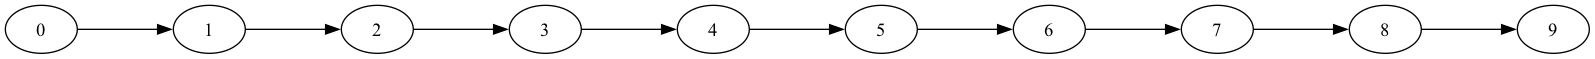

In [ ]:
num_qubits = 10
layout = [(i - 1, i) for i in range(1, num_qubits)]

# Instantiate a CouplingMap object
coupling_map = CouplingMap(layout)
graphviz_draw(coupling_map.graph, method="circo")

Next, we generate a Pauli operator modeling a Heisenberg XYZ Hamiltonian.

$$
{\hat{\mathcal{H}}_{XYZ} = \sum_{(j,k)\in E} (J_{x} \sigma_j^{x} \sigma_{k}^{x} + J_{y} \sigma_j^{y} \sigma_{k}^{y} + J_{z} \sigma_j^{z} \sigma_{k}^{z}) + \sum_{j\in V} (h_{x} \sigma_j^{x} + h_{y} \sigma_j^{y} + h_{z} \sigma_j^{z})}
$$

Where $G(V,E)$ is the graph of the coupling map provided.

In [ ]:
# Get a qubit operator describing the Heisenberg XYZ model
hamiltonian = generate_xyz_hamiltonian(
    coupling_map,
    coupling_constants=(np.pi / 8, np.pi / 4, np.pi / 2),
    ext_magnetic_field=(np.pi / 3, np.pi / 6, np.pi / 9),
)
print(hamiltonian)

SparsePauliOp(['IIIIIIIXXI', 'IIIIIIIYYI', 'IIIIIIIZZI', 'IIIIIXXIII', 'IIIIIYYIII', 'IIIIIZZIII', 'IIIXXIIIII', 'IIIYYIIIII', 'IIIZZIIIII', 'IXXIIIIIII', 'IYYIIIIIII', 'IZZIIIIIII', 'IIIIIIIIXX', 'IIIIIIIIYY', 'IIIIIIIIZZ', 'IIIIIIXXII', 'IIIIIIYYII', 'IIIIIIZZII', 'IIIIXXIIII', 'IIIIYYIIII', 'IIIIZZIIII', 'IIXXIIIIII', 'IIYYIIIIII', 'IIZZIIIIII', 'XXIIIIIIII', 'YYIIIIIIII', 'ZZIIIIIIII', 'IIIIIIIIIX', 'IIIIIIIIIY', 'IIIIIIIIIZ', 'IIIIIIIIXI', 'IIIIIIIIYI', 'IIIIIIIIZI', 'IIIIIIIXII', 'IIIIIIIYII', 'IIIIIIIZII', 'IIIIIIXIII', 'IIIIIIYIII', 'IIIIIIZIII', 'IIIIIXIIII', 'IIIIIYIIII', 'IIIIIZIIII', 'IIIIXIIIII', 'IIIIYIIIII', 'IIIIZIIIII', 'IIIXIIIIII', 'IIIYIIIIII', 'IIIZIIIIII', 'IIXIIIIIII', 'IIYIIIIIII', 'IIZIIIIIII', 'IXIIIIIIII', 'IYIIIIIIII', 'IZIIIIIIII', 'XIIIIIIIII', 'YIIIIIIIII', 'ZIIIIIIIII'],
              coeffs=[0.39269908+0.j, 0.78539816+0.j, 1.57079633+0.j, 0.39269908+0.j,
 0.78539816+0.j, 1.57079633+0.j, 0.39269908+0.j, 0.78539816+0.j,
 1.57079633+0.j, 0.39269908+0.j, 0.

From the qubit operator, we can generate a quantum circuit which models its time evolution.
Once again, the [qiskit_addon_utils.problem_generators](https://docs.quantum.ibm.com/api/qiskit-addon-utils/problem-generators) module comes to the rescue with a handy function do just that:

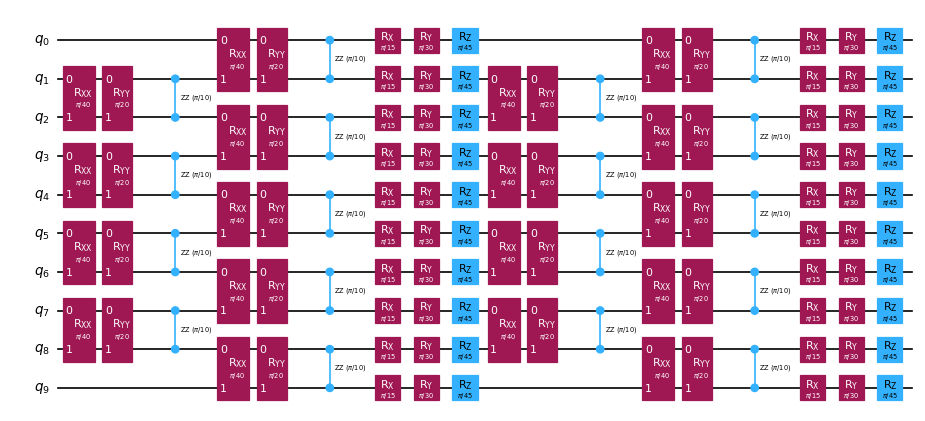

In [ ]:
circuit = generate_time_evolution_circuit(
    hamiltonian,
    time=0.2,
    synthesis=LieTrotter(reps=2),
)
circuit.draw("mpl", style="iqp", scale=0.6)

### Step 2: Optimize problem for quantum hardware execution
#### Create circuit slices to backpropagate

Remember, the ``backpropagate`` function will backpropagate entire circuit slices at a time, so the choice of how to slice can have an impact on how well backpropagation performs for a given problem. Here, we will group gates of the same type into slices using the [slice_by_gate_types](https://docs.quantum.ibm.com/api/qiskit-addon-utils/slicing#slice_by_gate_types) function.

For a more detailed discussion on circuit slicing, check out this [how-to guide](https://qiskit.github.io/qiskit-addon-utils/how_tos/create_circuit_slices.html) of the [qiskit-addon-utils](https://github.com/Qiskit/qiskit-addon-utils) package.

In [ ]:
slices = slice_by_gate_types(circuit)
print(f"Separated the circuit into {len(slices)} slices.")

Separated the circuit into 18 slices.


#### Constrain how large the operator may grow during backpropagation

During backpropagation, the number of terms in the operator will generally approach $4^N$ quickly, where $N$ is the number of qubits. When two terms in the operator do not commute qubit-wise, we need separate circuits to obtain the expectation values corresponding to them. For example, if we have a 2-qubit observable $O = 0.1 XX + 0.3 IZ - 0.5 IX$, then since $[XX,IX] = 0$, measurement in a single basis is sufficient to calculate the expectation values for these two terms. However, $IZ$ anti-commutes with the other two terms. So we need a separate basis measurement to calculate the expectation value of $IZ$. In other words, we need two, instead of one, circuit to calculate $\langle O \rangle$. As the number of terms in the operator increase, there is a possibility that the required number of circuit executions also increase.

The size of the operator can be bounded by specifying the ``operator_budget`` kwarg of the ``backpropagate`` function, which accepts an [OperatorBudget](https://docs.quantum.ibm.com/api/qiskit-addon-obp/utils-simplify#operatorbudget) instance.

To control the amount of extra resources (time) allocated, we restrict the maximum number of qubit-wise commuting Pauli groups that the backpropagated observable is allowed to have. Here we specify that backpropagation should stop when the number of qubit-wise commuting Pauli groups in the operator grows past 8.

In [ ]:
op_budget = OperatorBudget(max_qwc_groups=8)

#### Backpropagate slices from the circuit

First we specify the observable to be $M_Z = \frac{1}{N} \sum_{i=1}^N \langle Z_i \rangle$, $N$ being the number of qubits. We will backpropagate slices from the time-evolution circuit until the terms in the observable can no longer be combined into 8 or fewer qubit-wise commuting Pauli groups.

In [ ]:
observable = SparsePauliOp.from_sparse_list(
    [("Z", [i], 1 / num_qubits) for i in range(num_qubits)],
    num_qubits=num_qubits,
)
observable

SparsePauliOp(['IIIIIIIIIZ', 'IIIIIIIIZI', 'IIIIIIIZII', 'IIIIIIZIII', 'IIIIIZIIII', 'IIIIZIIIII', 'IIIZIIIIII', 'IIZIIIIIII', 'IZIIIIIIII', 'ZIIIIIIIII'],
              coeffs=[0.1+0.j, 0.1+0.j, 0.1+0.j, 0.1+0.j, 0.1+0.j, 0.1+0.j, 0.1+0.j, 0.1+0.j,
 0.1+0.j, 0.1+0.j])

Below you will see that we backpropagated 6 slices, and the terms were combined into 6 and not 8 groups. This implies that backpropagating one more slice would cause the number of Pauli groups to exceed 8. We can verify that this is the case by inspecting the returned metadata. Also note that in this portion the circuit transformation is exact, i.e., no terms of the new observable $O’$ were truncated. The backpropagated circuit and the backpropagated operator gives the exact outcome as the original circuit and operator.

Backpropagated 6 slices.
New observable has 60 terms, which can be combined into 6 groups.
Note that backpropagating one more slice would result in 114 terms across 12 groups.
The remaining circuit after backpropagation looks as follows:


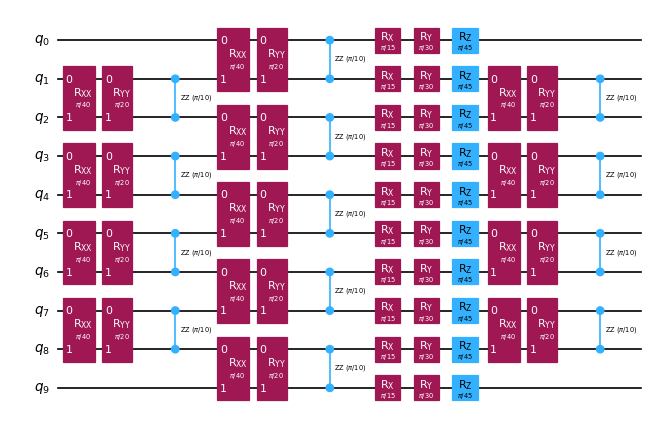

In [ ]:
# Backpropagate slices onto the observable
bp_obs, remaining_slices, metadata = backpropagate(
    observable, slices, operator_budget=op_budget
)
# Recombine the slices remaining after backpropagation
bp_circuit = combine_slices(remaining_slices)

print(f"Backpropagated {metadata.num_backpropagated_slices} slices.")
print(
    f"New observable has {len(bp_obs.paulis)} terms, which can be combined into {len(bp_obs.group_commuting(qubit_wise=True))} groups."
)
print(
    f"Note that backpropagating one more slice would result in {metadata.backpropagation_history[-1].num_paulis[0]} terms "
    f"across {metadata.backpropagation_history[-1].num_qwc_groups} groups."
)
print("The remaining circuit after backpropagation looks as follows:")
bp_circuit.draw("mpl", fold=-1, scale=0.6)

Next, we will specify the same problem with the same constraints on the size of the output observable. However, this time, we allot an error budget to each slice using the [setup_budget](https://docs.quantum.ibm.com/api/qiskit-addon-obp/utils-truncating#setup_budget) function. Pauli terms with small coefficients will be truncated from each slice until the error budget is filled, and leftover budget will be added to the following slice's budget. Note that in this case, the transformation due to backpropagation is approximate since some of the terms in the operator are truncated.

In order to enable this truncation, we need to setup our error budget like so:

In [ ]:
truncation_error_budget = setup_budget(max_error_per_slice=0.005)

Note that by allocating `5e-3` error per slice for truncation, we are able to remove 1 more slice from the circuit, while remaining within the original budget of 8 commuting Pauli groups in the observable. By default, `backpropagate` uses the L1 norm of the truncated coefficients to bound the total error incurred from truncation. For other options refer to the [how-to guide on specifying the p_norm](https://qiskit.github.io/qiskit-addon-obp/how_tos/bound_error_using_p_norm.html).

In this particular example where we have backpropagated 7 slices, the total truncation error should not exceed ``(5e-3 error/slice) * (7 slices) = 3.5e-2``.
For further discussion on distributing an error budget across your slices, check out [this how-to guide](https://qiskit.github.io/qiskit-addon-obp/how_tos/truncate_operator_terms.html).

Backpropagated 7 slices.
New observable has 82 terms, which can be combined into 8 groups.
After truncation, the error in our observable is bounded by 3.266e-02
Note that backpropagating one more slice would result in 114 terms across 12 groups.
The remaining circuit after backpropagation looks as follows:


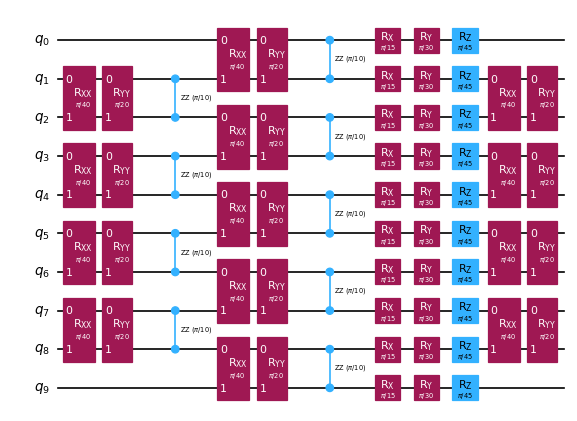

In [ ]:
# Run the same experiment but truncate observable terms with small coefficients
bp_obs_trunc, remaining_slices_trunc, metadata = backpropagate(
    observable,
    slices,
    operator_budget=op_budget,
    truncation_error_budget=truncation_error_budget,
)

# Recombine the slices remaining after backpropagation
bp_circuit_trunc = combine_slices(
    remaining_slices_trunc, include_barriers=False
)

print(f"Backpropagated {metadata.num_backpropagated_slices} slices.")
print(
    f"New observable has {len(bp_obs_trunc.paulis)} terms, which can be combined into {len(bp_obs_trunc.group_commuting(qubit_wise=True))} groups.\n"
    f"After truncation, the error in our observable is bounded by {metadata.accumulated_error(0):.3e}"
)
print(
    f"Note that backpropagating one more slice would result in {metadata.backpropagation_history[-1].num_paulis[0]} terms "
    f"across {metadata.backpropagation_history[-1].num_qwc_groups} groups."
)
print("The remaining circuit after backpropagation looks as follows:")
bp_circuit_trunc.draw("mpl", scale=0.6)

We note that truncation allows us to backpropagate further without increase in the number of commuting groups in the observable.

#### Now that we have our reduced ansatz and expanded observables, we can transpile our experiments to the backend.

Here we will use a 127-qubit IBM Quantum hardware to demonstrate how to transpile to a QPU backend.

In [ ]:
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(
    operational=True, simulator=False, min_num_qubits=127
)

In [ ]:
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)

# Transpile original experiment
circuit_isa = pm.run(circuit)
observable_isa = observable.apply_layout(circuit_isa.layout)

# Transpile backpropagated experiment
bp_circuit_isa = pm.run(bp_circuit)
bp_obs_isa = bp_obs.apply_layout(bp_circuit_isa.layout)

# Transpile the backpropagated experiment with truncated observable terms
bp_circuit_trunc_isa = pm.run(bp_circuit_trunc)
bp_obs_trunc_isa = bp_obs_trunc.apply_layout(bp_circuit_trunc_isa.layout)

We create the <a href="https://docs.quantum.ibm.com/guides/primitive-input-output">Primitive Unified Bloc (PUB)</a> for each of the three cases.

In [ ]:
pub = (circuit_isa, observable_isa)
bp_pub = (bp_circuit_isa, bp_obs_isa)
bp_trunc_pub = (bp_circuit_trunc_isa, bp_obs_trunc_isa)

### Step 3: Execute using Qiskit primitives
#### Calculate expectation value

Finally, we can run the backpropagated experiments and compare them with the full experiment using the noiseless [StatevectorEstimator](https://docs.quantum.ibm.com/api/qiskit/qiskit.primitives.StatevectorEstimator).

In [ ]:
ideal_estimator = Estimator()

# Run the experiments using Estimator primitive to obtain the exact outcome
result_exact = (
    ideal_estimator.run([(circuit, observable)]).result()[0].data.evs.item()
)
print(f"Exact expectation value: {result_exact}")

Exact expectation value: 0.8871244838989424


We shall use <a href="https://docs.quantum.ibm.com/guides/configure-error-mitigation">resilience_level</a> = 2 for this example.

In [ ]:
options = EstimatorOptions()
options.default_precision = 0.011
options.resilience_level = 2

estimator = EstimatorV2(mode=backend, options=options)

In [ ]:
job = estimator.run([pub, bp_pub, bp_trunc_pub])

### Step 4: Post-process and return result to desired classical format

In [ ]:
result_no_bp = job.result()[0].data.evs.item()
result_bp = job.result()[1].data.evs.item()
result_bp_trunc = job.result()[2].data.evs.item()

In [ ]:
print(f"Expectation value without backpropagation: {result_no_bp}")
print(f"Backpropagated expectation value: {result_bp}")
print(f"Backpropagated expectation value with truncation: {result_bp_trunc}")

Expectation value without backpropagation: 0.8033194665993642
Backpropagated expectation value: 0.8599808781259016
Backpropagated expectation value with truncation: 0.8868736004169483


Text(0, 0.5, '$M_Z$')

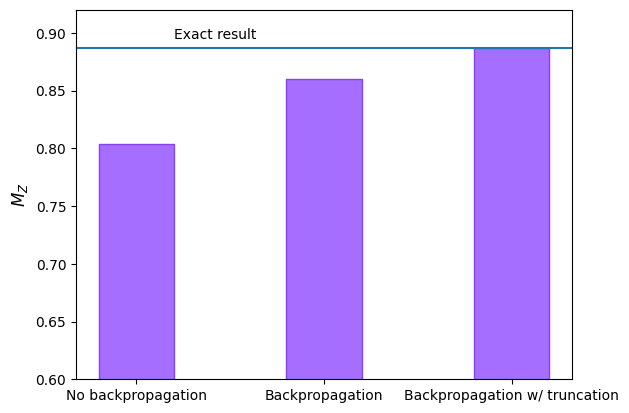

In [ ]:
methods = [
    "No backpropagation",
    "Backpropagation",
    "Backpropagation w/ truncation",
]
values = [result_no_bp, result_bp, result_bp_trunc]
stds = [std_no_bp, std_bp, std_bp_trunc]

ax = plt.gca()
plt.bar(methods, values, color="#a56eff", width=0.4, edgecolor="#8a3ffc")
plt.axhline(result_exact)
ax.set_ylim([0.6, 0.92])
plt.text(0.2, 0.895, "Exact result")
ax.set_ylabel(r"$M_Z$", fontsize=12)

## Part B: Scale it up!

Let us now use Operator Backpropagation to study the dynamics of the Hamiltonian of a 50-qubit Heisenberg Spin Chain.

### Step 1: Map classical inputs to a quantum problem

We consider a 50-qubit Hamiltonian $\hat{\mathcal{H}}_{XYZ}$ for the scaled up problem with the same values for the $J$ and $h$ coefficients as in the small-scale example. The observable $M_Z = \frac{1}{N} \sum_{i=1}^N \langle Z_i \rangle$ is also the same as before. This problem is beyond classical brute-force simulation.

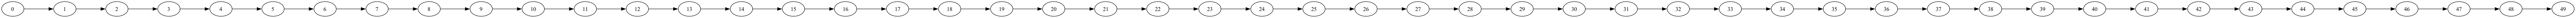

In [ ]:
num_qubits = 50
layout = [(i - 1, i) for i in range(1, num_qubits)]

# Instantiate a CouplingMap object
coupling_map = CouplingMap(layout)
graphviz_draw(coupling_map.graph, method="circo")

In [ ]:
hamiltonian = generate_xyz_hamiltonian(
    coupling_map,
    coupling_constants=(np.pi / 8, np.pi / 4, np.pi / 2),
    ext_magnetic_field=(np.pi / 3, np.pi / 6, np.pi / 9),
)
print(hamiltonian)

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIXXI', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIYYI', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZI', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIXXIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIYYIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIXXIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIYYIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIXXIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIYYIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIXXIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIYYIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIXXIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIYYIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIIIII', 'IIIIIIIIIIII

In [ ]:
observable = SparsePauliOp.from_sparse_list(
    [("Z", [i], 1 / num_qubits) for i in range(num_qubits)],
    num_qubits=num_qubits,
)
observable

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZI', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIII', 'IIIIIIIIIIII

For this scaled up problem we have considered the time of evolution as $0.2$ with $4$ trotter steps. The problem is selected so that it is beyond classical brute-force simulation, but can be simulated by tensor network method. This allows us to verify the outcome obtained via backpropagation on a quantum computer with the ideal outcome.

The ideal expectation value for this problem, as obtained via tensor network simulation, is $\simeq 0.89$.

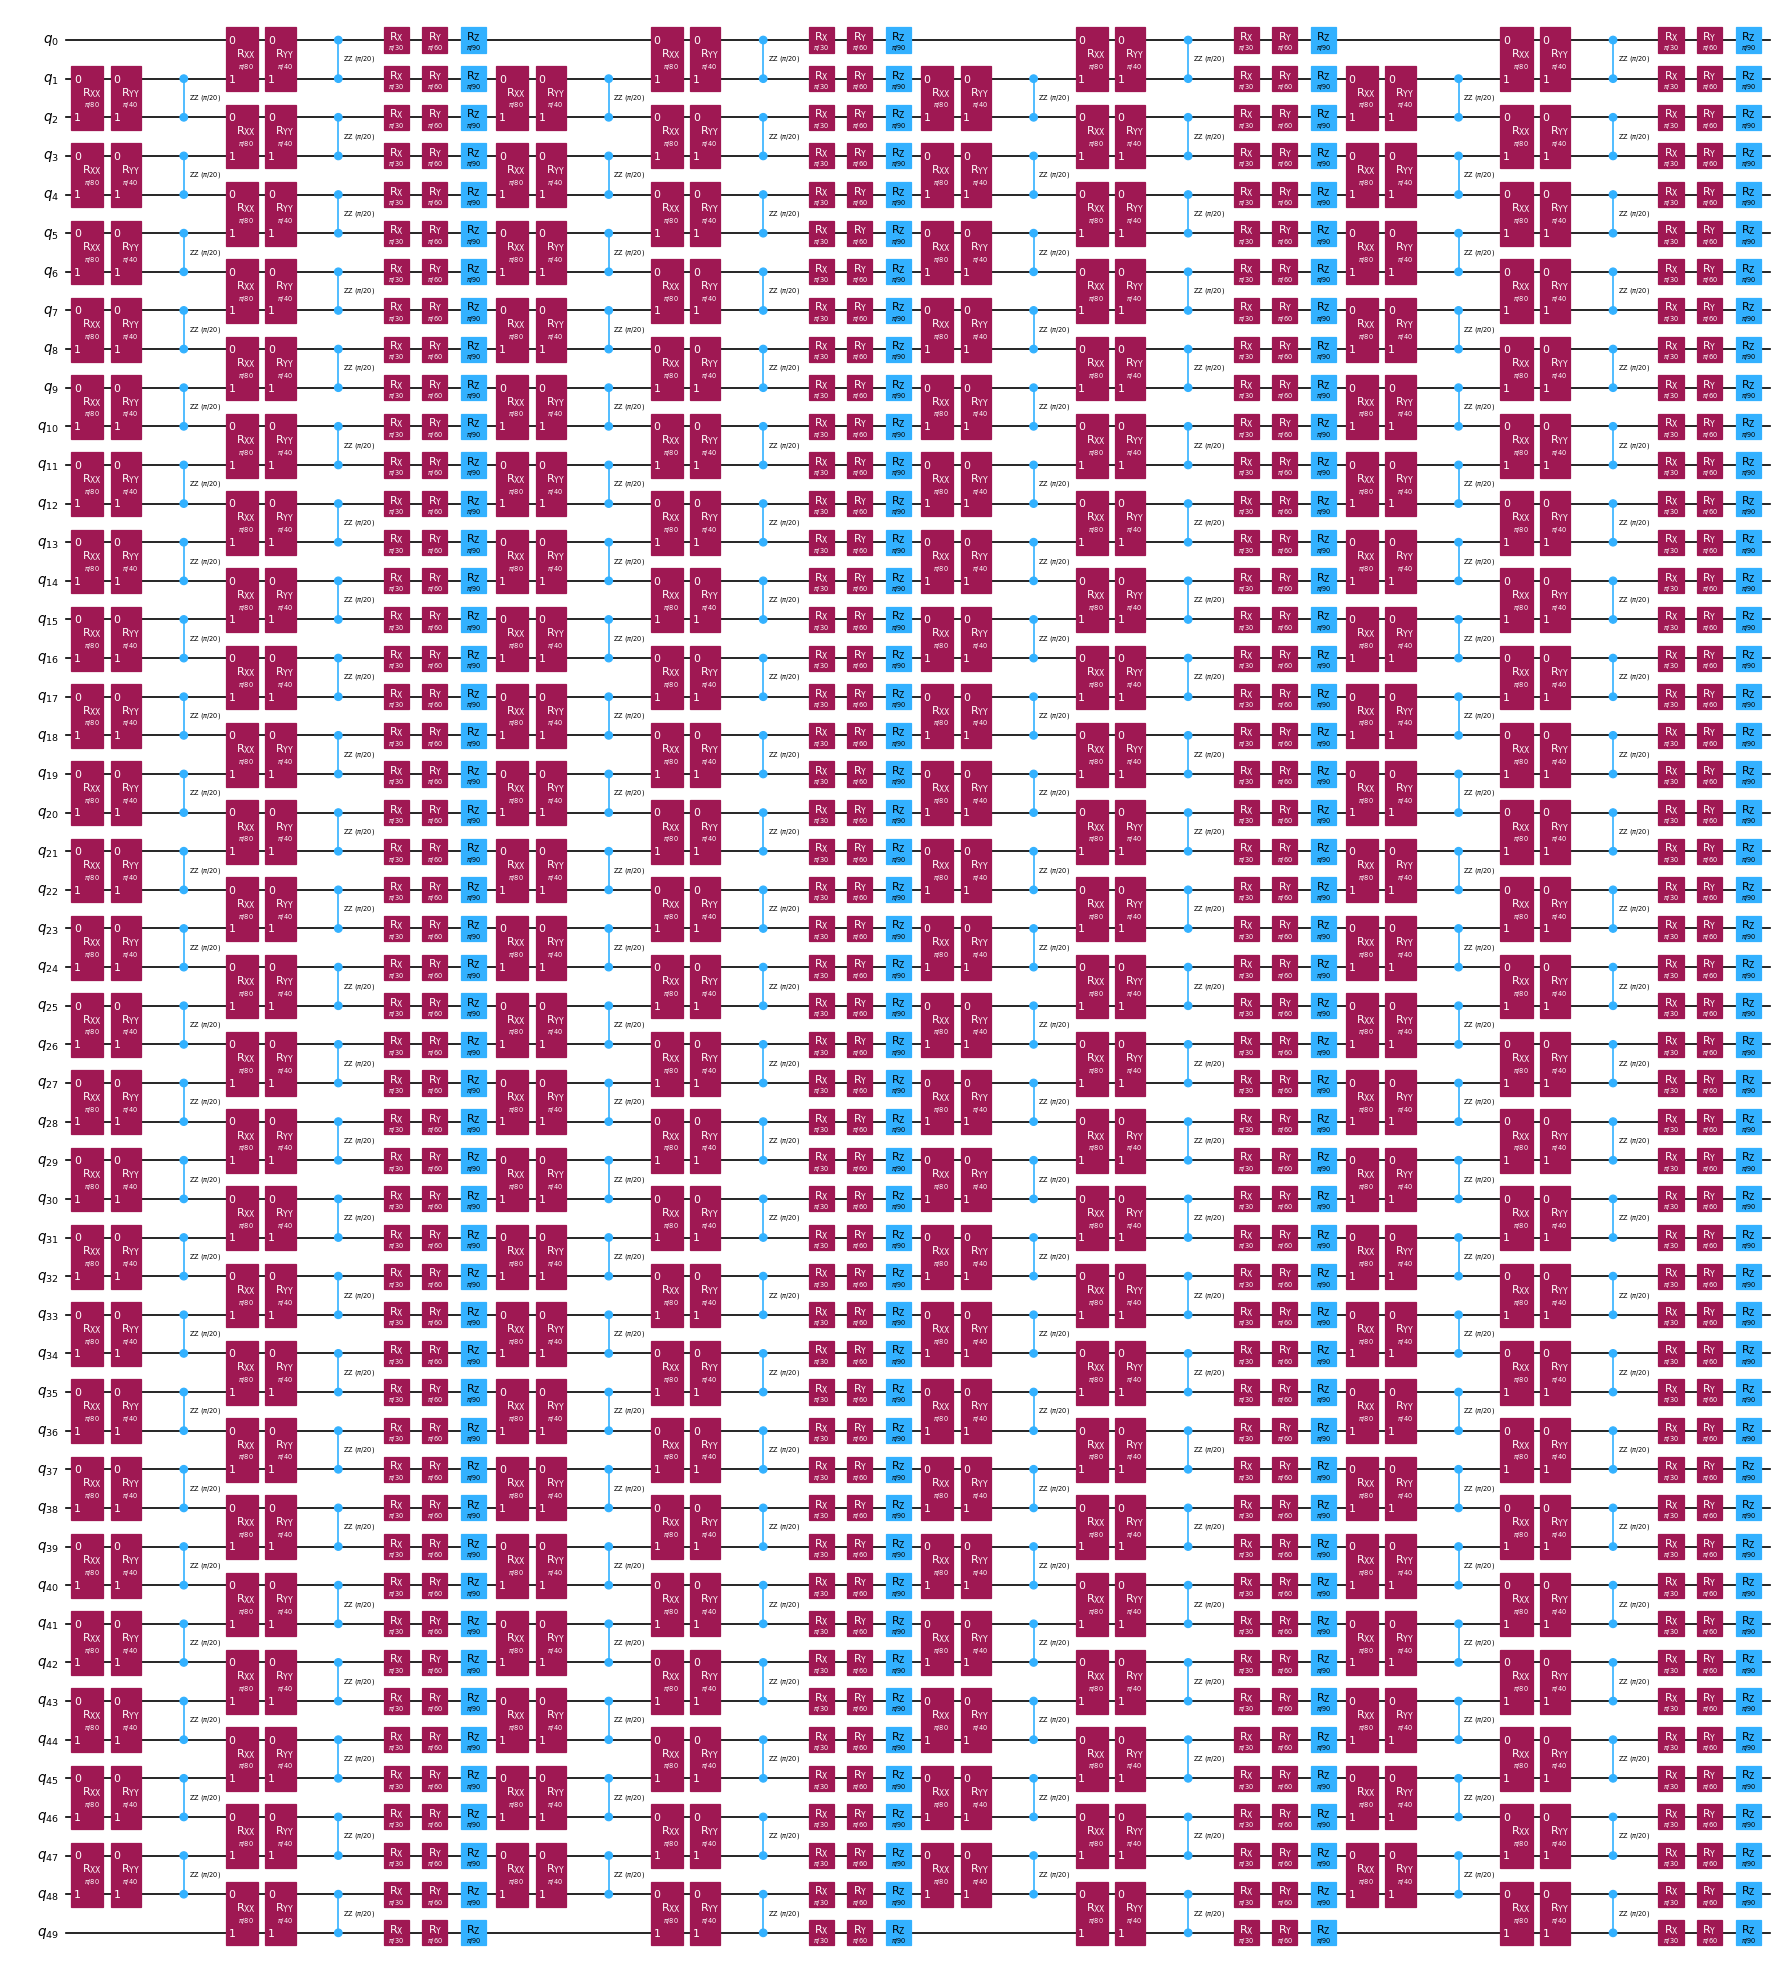

In [ ]:
circuit = generate_time_evolution_circuit(
    hamiltonian,
    time=0.2,
    synthesis=LieTrotter(reps=4),
)
circuit.draw("mpl", style="iqp", fold=-1, scale=0.6)

### Step 2: Optimize problem for quantum hardware execution

In [ ]:
slices = slice_by_gate_types(circuit)
print(f"Separated the circuit into {len(slices)} slices.")

Separated the circuit into 36 slices.


We specify the `max_error_per_slice` to be 0.005 as before. However, since the number of slices for this large-scale problem is much higher than the small scale problem, allowing an error of 0.005 per slice may end up creating a large overall backpropagation error. We can bound this by specifying `max_error_total` which bounds the total backpropagation error, and we set its value to 0.03 (which is roughly the same as in the small-scale example).

For this large-scale example, we allow a higher value for the number of commuting groups, and set it to 15.

In [ ]:
op_budget = OperatorBudget(max_qwc_groups=15)
truncation_error_budget = setup_budget(
    max_error_total=0.03, max_error_per_slice=0.005
)

Let us first obtain the backpropagated circuit and observable without any truncation.

Backpropagated 7 slices.
New observable has 634 terms, which can be combined into 12 groups.
Note that backpropagating one more slice would result in 1246 terms across 27 groups.
The remaining circuit after backpropagation looks as follows:


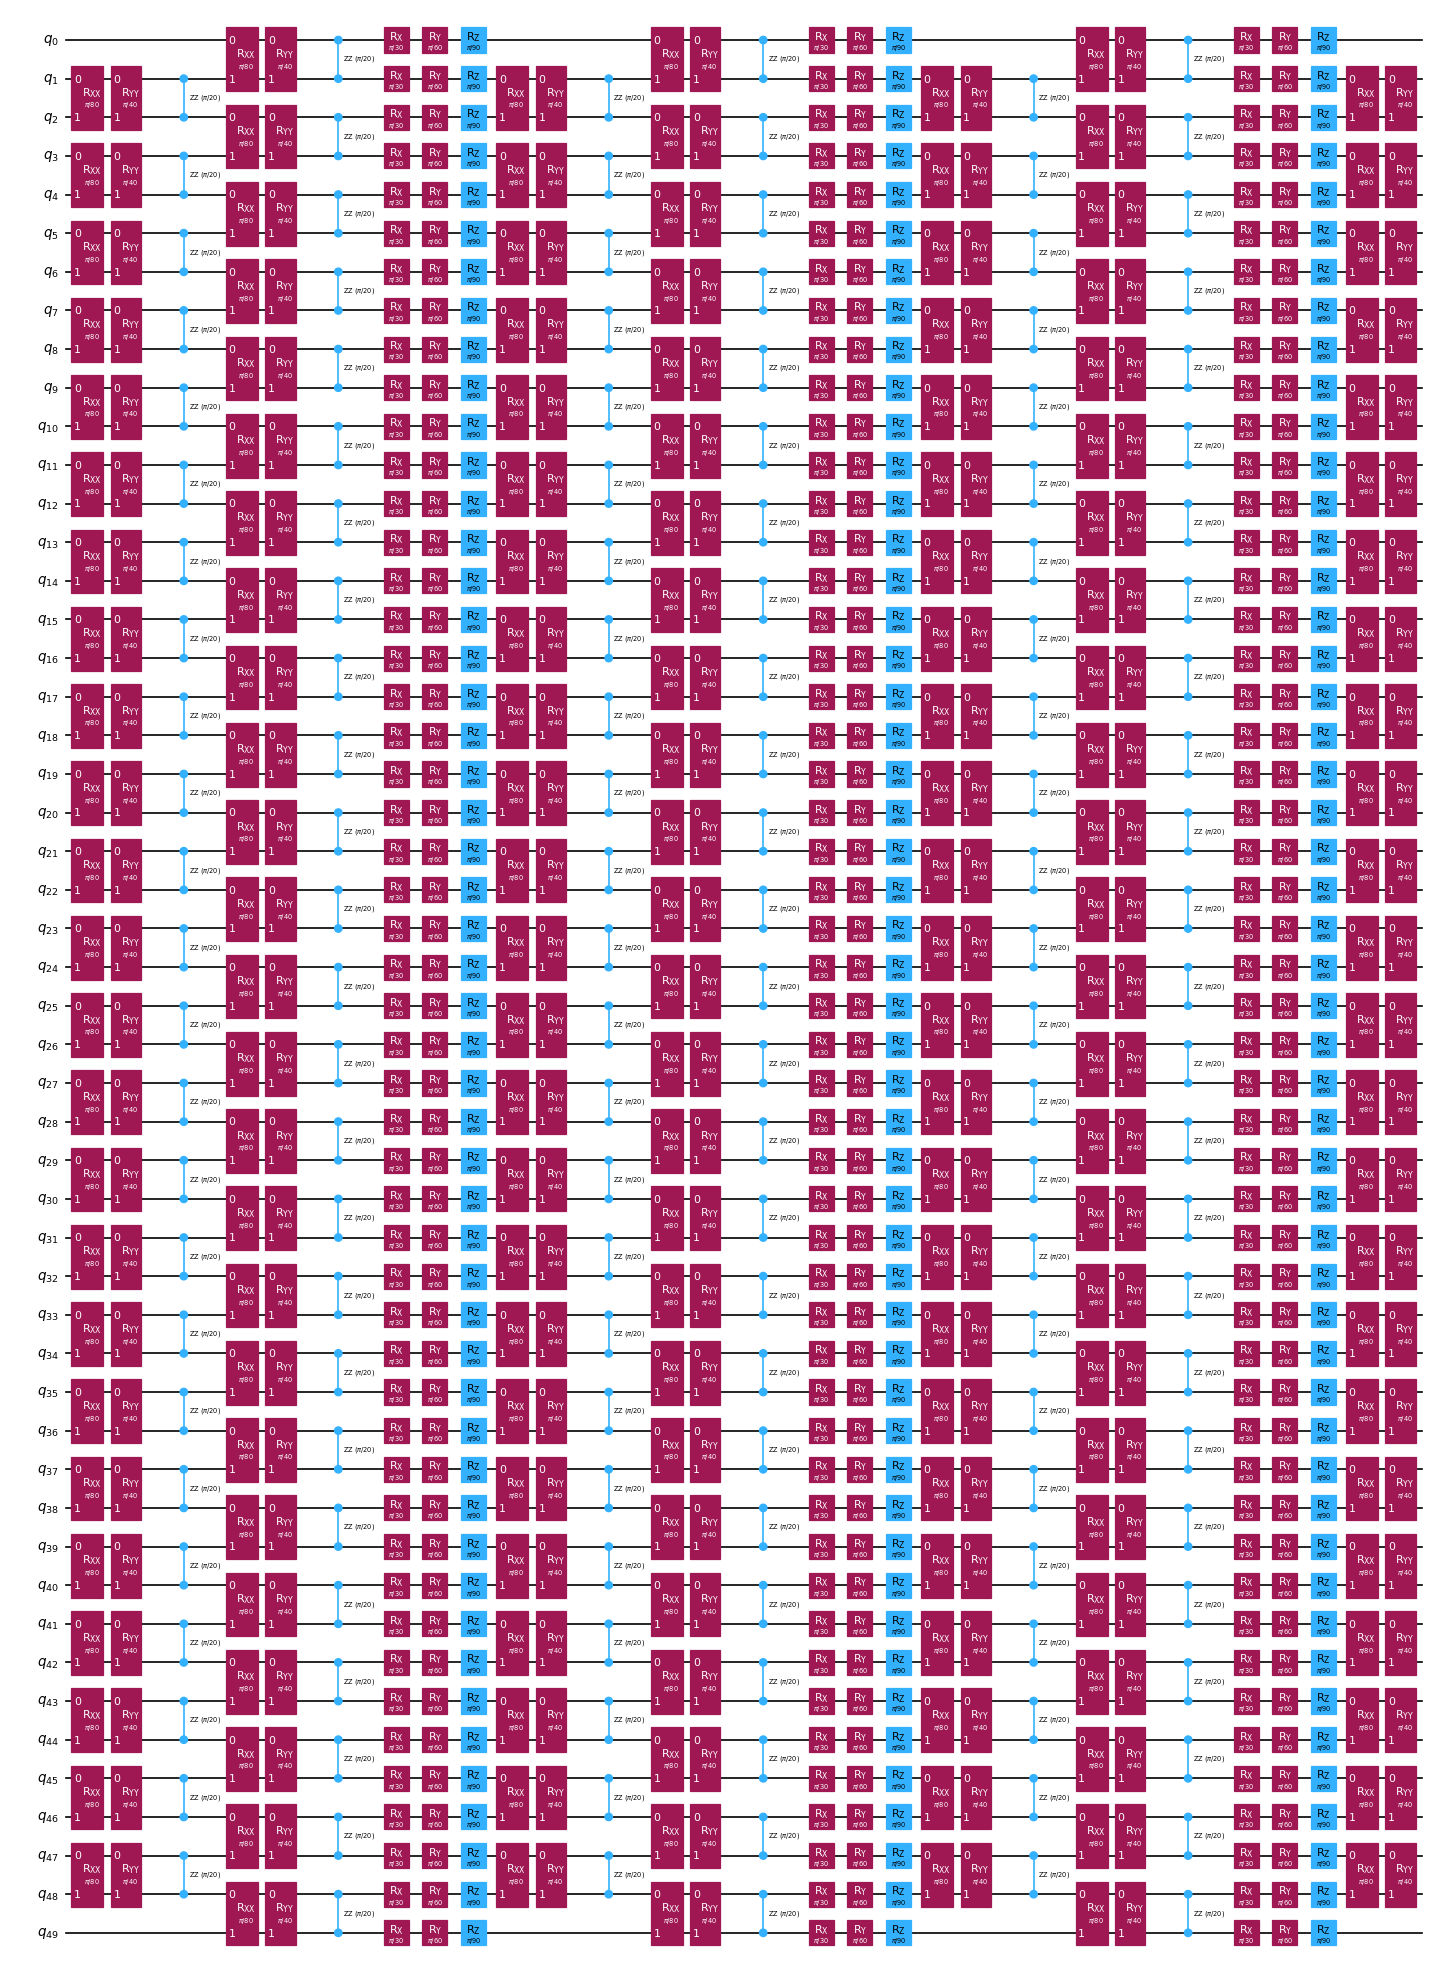

In [ ]:
bp_obs, remaining_slices, metadata = backpropagate(
    observable, slices, operator_budget=op_budget
)
bp_circuit = combine_slices(remaining_slices)

print(f"Backpropagated {metadata.num_backpropagated_slices} slices.")
print(
    f"New observable has {len(bp_obs.paulis)} terms, which can be combined into {len(bp_obs.group_commuting(qubit_wise=True))} groups."
)
print(
    f"Note that backpropagating one more slice would result in {metadata.backpropagation_history[-1].num_paulis[0]} terms "
    f"across {metadata.backpropagation_history[-1].num_qwc_groups} groups."
)
print("The remaining circuit after backpropagation looks as follows:")
bp_circuit.draw("mpl", fold=-1, scale=0.6)

Now allowing for truncation, we obtain:

Backpropagated 10 slices.
New observable has 646 terms, which can be combined into 14 groups.
After truncation, the error in our observable is bounded by 2.998e-02
Note that backpropagating one more slice would result in 1184 terms across 30 groups.
The remaining circuit after backpropagation looks as follows:


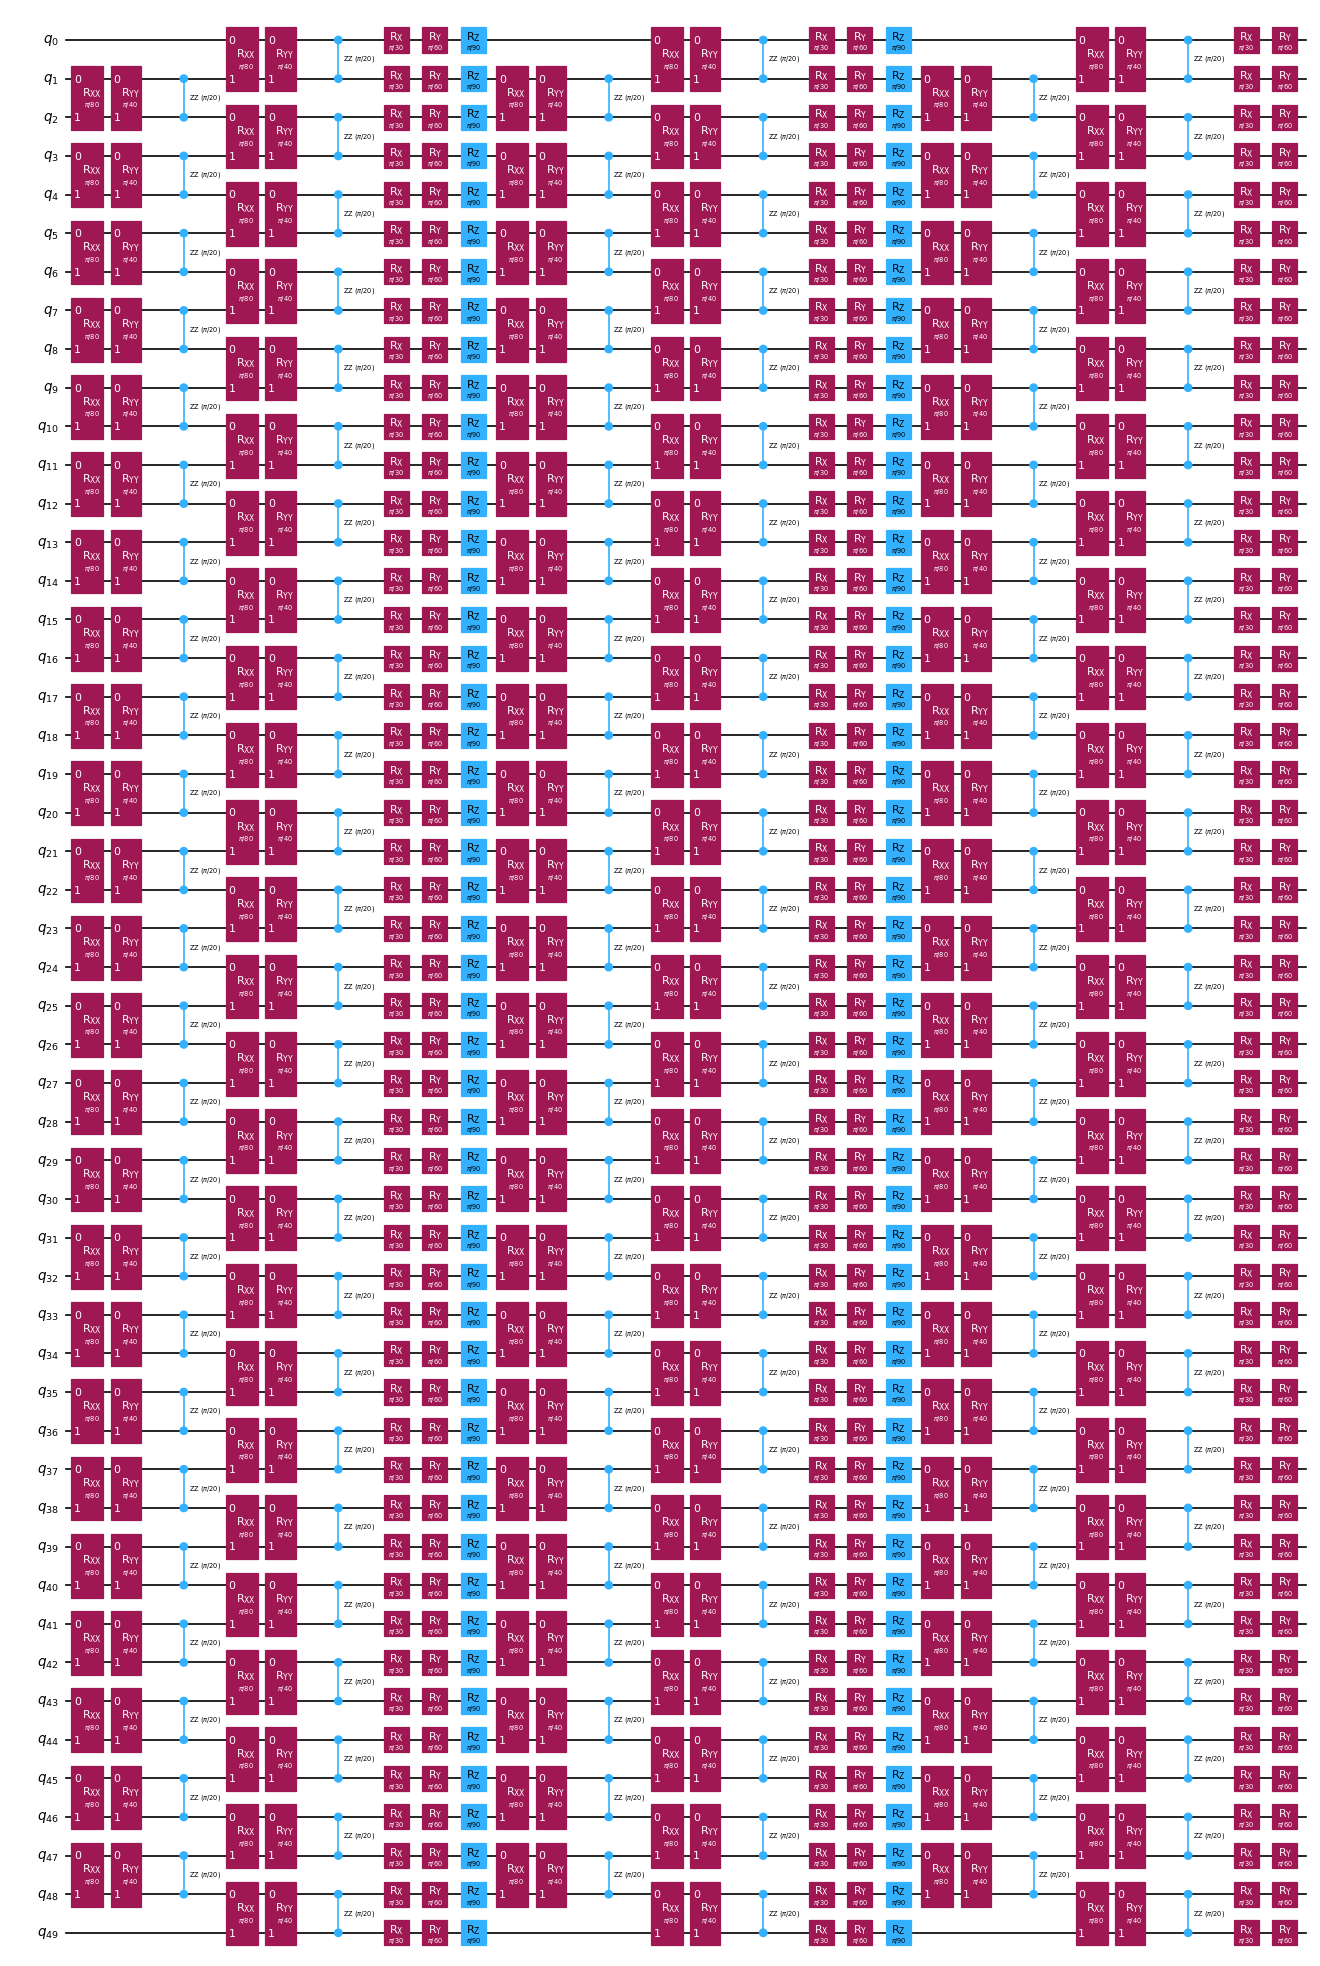

In [ ]:
bp_obs_trunc, remaining_slices_trunc, metadata = backpropagate(
    observable,
    slices,
    operator_budget=op_budget,
    truncation_error_budget=truncation_error_budget,
)

# Recombine the slices remaining after backpropagation
bp_circuit_trunc = combine_slices(
    remaining_slices_trunc, include_barriers=False
)

print(f"Backpropagated {metadata.num_backpropagated_slices} slices.")
print(
    f"New observable has {len(bp_obs_trunc.paulis)} terms, which can be combined into {len(bp_obs_trunc.group_commuting(qubit_wise=True))} groups.\n"
    f"After truncation, the error in our observable is bounded by {metadata.accumulated_error(0):.3e}"
)
print(
    f"Note that backpropagating one more slice would result in {metadata.backpropagation_history[-1].num_paulis[0]} terms "
    f"across {metadata.backpropagation_history[-1].num_qwc_groups} groups."
)
print("The remaining circuit after backpropagation looks as follows:")
bp_circuit_trunc.draw("mpl", fold=-1, scale=0.6)

We note that allowing truncation leads to the backpropagation of three more slices. We can verify the 2-qubit depth of the original circuit, the backpropagated circuit, and the backpropagated circuit with truncation after transpilation.

In [ ]:
# Transpile original experiment
circuit_isa = pm.run(circuit)
observable_isa = observable.apply_layout(circuit_isa.layout)

# Transpile the backpropagated experiment
bp_circuit_isa = pm.run(bp_circuit)
bp_obs_isa = bp_obs_trunc.apply_layout(bp_circuit_isa.layout)

# Transpile the backpropagated experiment with truncated observable terms
bp_circuit_trunc_isa = pm.run(bp_circuit_trunc)
bp_obs_trunc_isa = bp_obs_trunc.apply_layout(bp_circuit_trunc_isa.layout)

In [ ]:
print(
    f"2-qubit depth of original circuit: {circuit_isa.depth(lambda x:x.operation.num_qubits==2)}"
)
print(
    f"2-qubit depth of backpropagated circuit: {bp_circuit_isa.depth(lambda x:x.operation.num_qubits==2)}"
)
print(
    f"2-qubit depth of backpropagated circuit with truncation: {bp_circuit_trunc_isa.depth(lambda x:x.operation.num_qubits==2)}"
)

2-qubit depth of original circuit: 48
2-qubit depth of backpropagated circuit: 40
2-qubit depth of backpropagated circuit with truncation: 36


### Step 3: Execute using Qiskit primitives

In [ ]:
pubs = [
    (circuit_isa, observable_isa),
    (bp_circuit_isa, bp_obs_isa),
    (bp_circuit_trunc_isa, bp_obs_trunc_isa),
]

In [ ]:
options = EstimatorOptions()
options.default_precision = 0.01
options.resilience_level = 2
options.resilience.zne.noise_factors = [1, 1.2, 1.4]
options.resilience.zne.extrapolator = ["linear"]

estimator = EstimatorV2(mode=backend, options=options)

In [ ]:
job = estimator.run(pubs)

### Step 4: Post-process and return result to desired classical format

In [ ]:
result_no_bp = job.result()[0].data.evs.item()
result_bp = job.result()[1].data.evs.item()
result_bp_trunc = job.result()[2].data.evs.item()

In [ ]:
print(f"Expectation value without backpropagation: {result_no_bp}")
print(f"Backpropagated expectation value: {result_bp}")
print(f"Backpropagated expectation value with truncation: {result_bp_trunc}")

Expectation value without backpropagation: 0.7887194658035515
Backpropagated expectation value: 0.9532818300978584
Backpropagated expectation value with truncation: 0.8913400398926913


Text(0, 0.5, '$M_Z$')

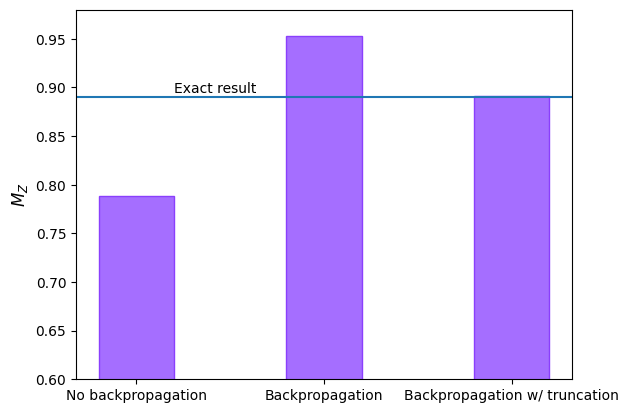

In [ ]:
methods = [
    "No backpropagation",
    "Backpropagation",
    "Backpropagation w/ truncation",
]
values = [result_no_bp, result_bp, result_bp_trunc]

ax = plt.gca()
plt.bar(methods, values, color="#a56eff", width=0.4, edgecolor="#8a3ffc")
plt.axhline(0.89)
ax.set_ylim([0.6, 0.98])
plt.text(0.2, 0.895, "Exact result")
ax.set_ylabel(r"$M_Z$", fontsize=12)

## Tutorial survey

Please take one minute to provide feedback on this tutorial. Your insights will help us improve our content offerings and user experience.

[Link to survey](https://your.feedback.ibm.com/jfe/form/SV_6LpyEKfDKBjqsWW)

© IBM Corp. 2024